In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%run 0_parameters.ipynb

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload

This notebook introduces the problem addressed in this paper:

 - localizating an object in a large image
 - foveation
 - action (saccade)
       
      
Using filename= ../data/2019-04-05
{'w': 28, 'minibatch_size': 100, 'train_batch_size': 50000, 'test_batch_size': 10000, 'noise_batch_size': 1000, 'mean': 0.1307, 'std': 0.3081, 'N_pic': 128, 'offset_std': 30, 'offset_max': 34, 'noise': 0.75, 'contrast': 0.5, 'sf_0': 0.2, 'B_sf': 0.08, 'N_theta': 6, 'N_azimuth': 26, 'N_eccentricity': 10, 'N_phase': 2, 'rho': 1.41, 'bias_deconv': True, 'p_dropout': 0.0, 'dim1': 382, 'dim2': 618, 'lr': 0.005, 'do_adam': True, 'bn1_bn_momentum': 0.5, 'bn2_bn_momentum': 0.5, 'momentum': 0.3, 'epochs': 25, 'num_processes': 1, 'no_cuda': True, 'log_interval': 100, 'verbose': 1, 'filename': '../data/2019-04-05', 'seed': 2019, 'N_cv': 10, 'do_compute': True}
Overwriting train.py
2019-04-05T12:12:18+02:00

CPython 3.7.2
IP

In [3]:
figname = '../paper/fig_methods'

# Definition of the input and the output 

## Representation of input image (retina)

In [4]:
from retina import Display
d = Display(args)

In [5]:
from retina import Retina
r = Retina(args)

In [51]:
data, label = next(iter(d.loader_test))
idx = 4
data_fullfield, i_offset, j_offset = d.draw(data[idx, 0, :, :].numpy())
data_retina = r.retina(data_fullfield)

In [85]:
#data_fullfield, i_offset, j_offset = d.draw(data[idx, 0, :, :].numpy(), noise=0, contrast=1)
#def place_object(data, i_offset, j_offset, im_noise=None, N_pic=128, contrast=1., noise=.5, sf_0=0.1, B_sf=0.1, do_mask=True, do_max=False):
from retina import place_object
im_mnist = place_object(data[idx, 0, :, :], i_offset, j_offset, im_noise=None, N_pic=128, contrast=1., noise=0., sf_0=0.1, B_sf=0.1, do_mask=True, do_max=False)

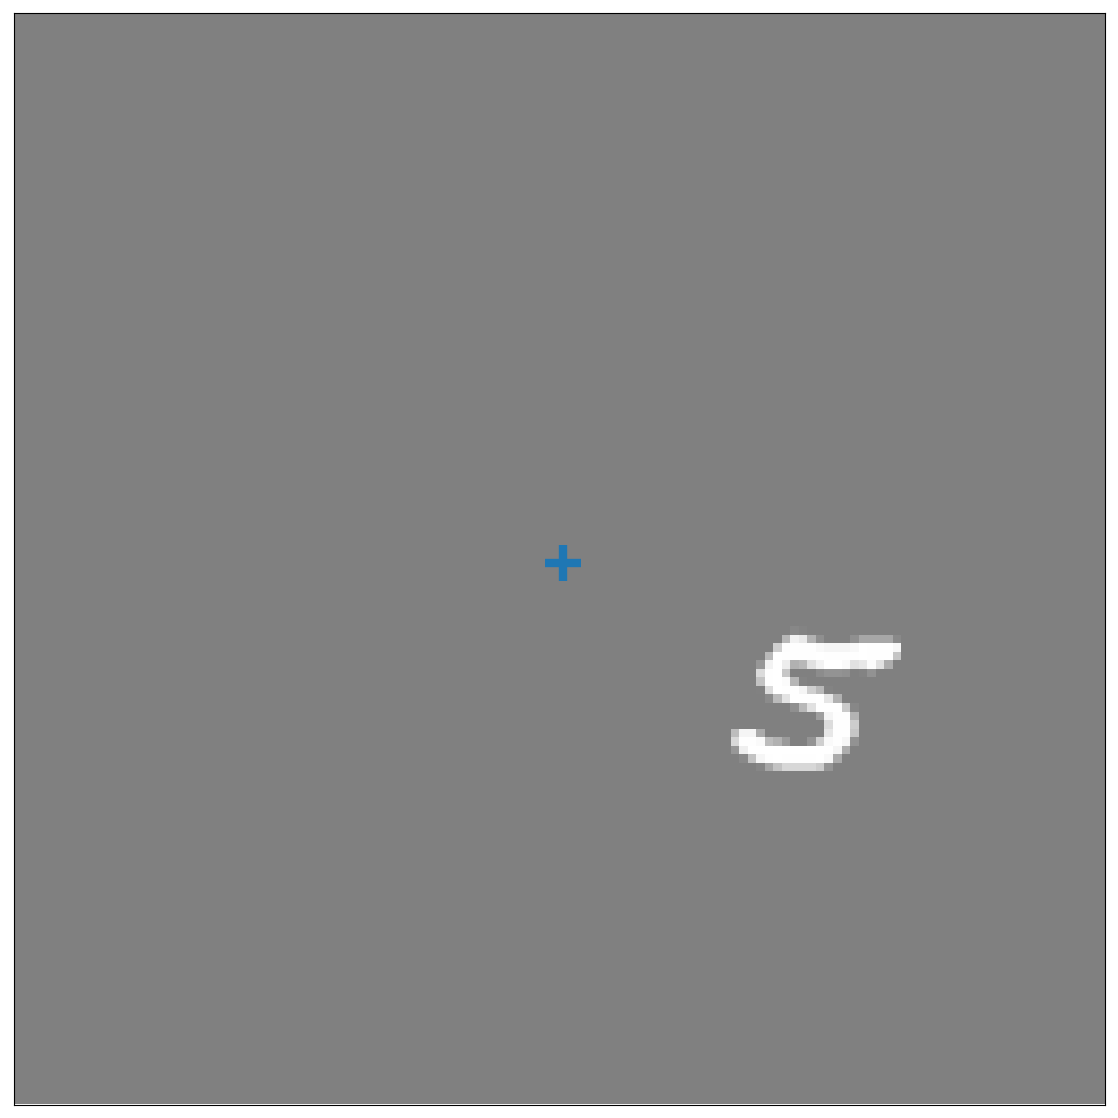

In [86]:
fig, axs = plt.subplots(1, 1, figsize = (figwidth, figwidth))
axs = d.show(axs, im_mnist)

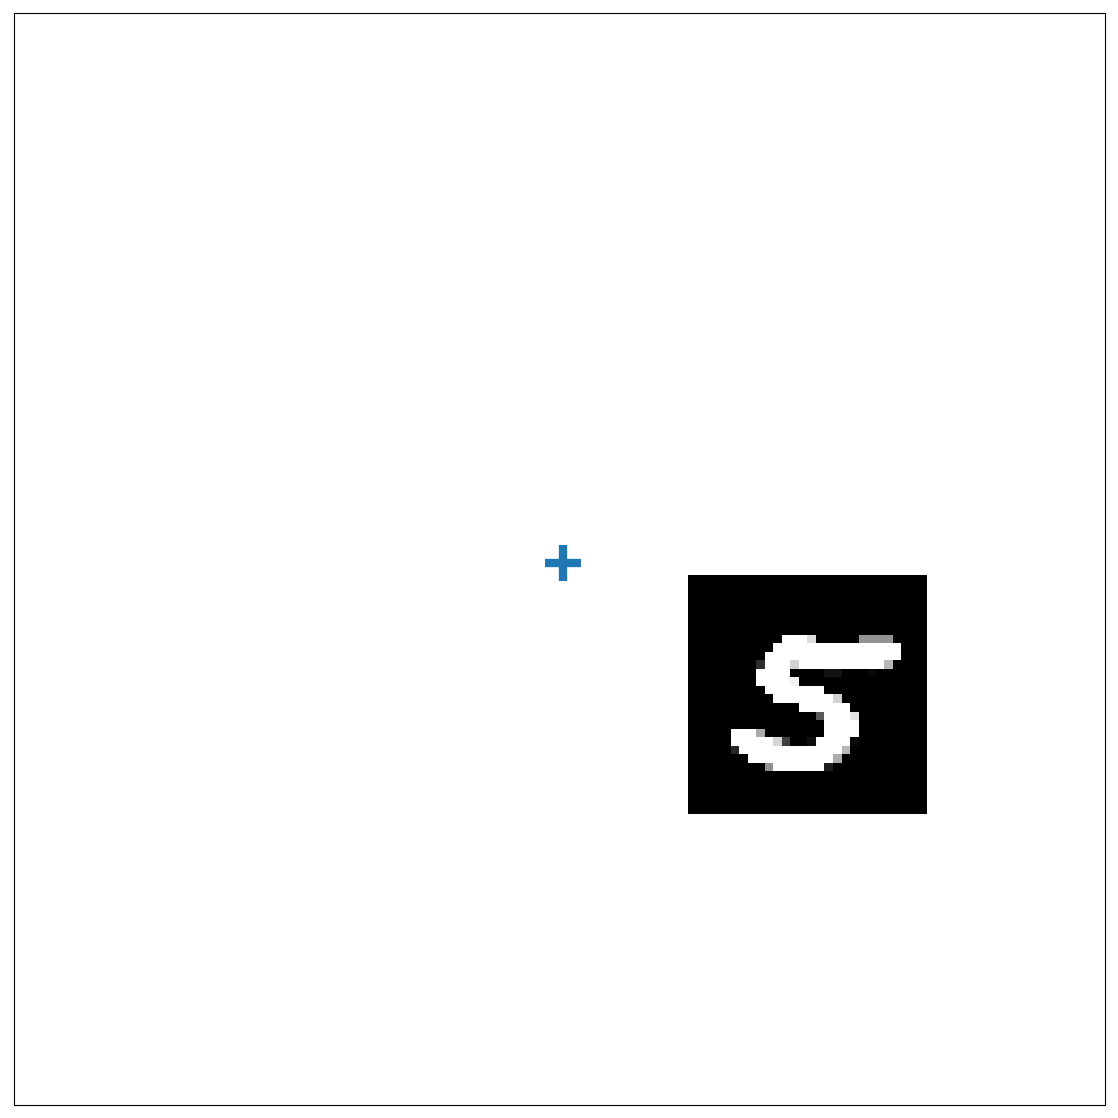

In [97]:
#data_fullfield, i_offset, j_offset = d.draw(data[idx, 0, :, :].numpy(), noise=0, contrast=1)
#def place_object(data, i_offset, j_offset, im_noise=None, N_pic=128, contrast=1., noise=.5, sf_0=0.1, B_sf=0.1, do_mask=True, do_max=False):
from retina import do_offset
im_mnist = do_offset(data[idx, 0, :, :], i_offset=i_offset, j_offset=j_offset, N_pic=128, data_min=2.)

im_mnist[im_mnist==2.] *= np.nan

fig, axs = plt.subplots(1, 1, figsize = (figwidth, figwidth))
axs = d.show(axs, im_mnist)

In [56]:
from retina import MotionCloudNoise
im_noise, _ = MotionCloudNoise(sf_0=args.sf_0, B_sf=args.B_sf)

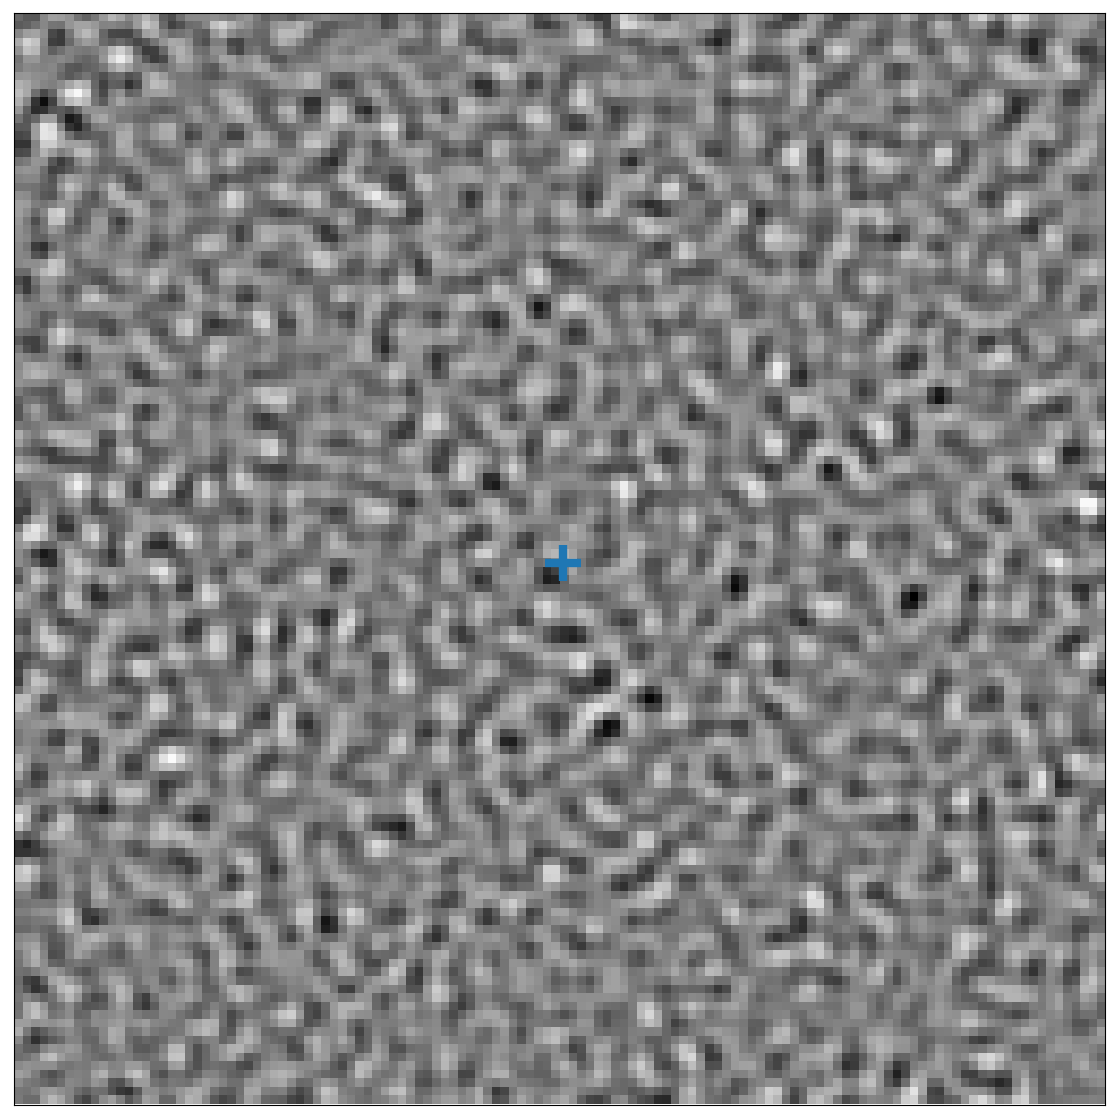

In [57]:
fig, axs = plt.subplots(1, 1, figsize = (figwidth, figwidth))
axs = d.show(axs, im_noise)

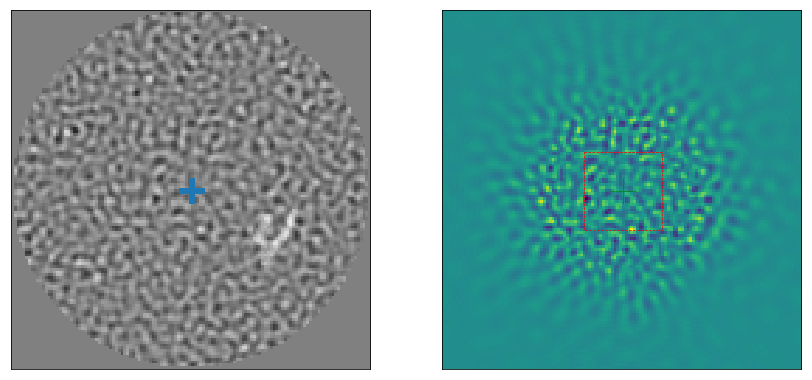

In [7]:
fig, axs = plt.subplots(1, 2, figsize = (figwidth, figwidth/2))
axs[0] = d.show(axs[0], data_fullfield)
axs[1] = r.show(axs[1], r.retina_invert(data_retina))


https://stackoverflow.com/questions/30464117/plotting-a-imshow-image-in-3d-in-matplotlib#30465073

arrows = 
https://stackoverflow.com/questions/29188612/arrows-in-matplotlib-using-mplot3d

In [108]:
args.N_pic


128

In [ ]:

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)


In [128]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from matplotlib import cm

X, Y = np.meshgrid(np.arange(args.N_pic), np.arange(args.N_pic))
mask = np.ones_like(X) * .5
mask[(X-args.N_pic//2)**2 + (Y-args.N_pic//2)**2 <(args.N_pic//2)**2] *= np.nan
mask[0, 0] = 0
mask[127, 0] = 1

contour = np.ones_like(X) * 1.
contour[X==0] *= 0.
contour[X==args.N_pic-1] *= 0.
contour[Y==0] *= 0.
contour[Y==args.N_pic-1] *= 0.

from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

class Arrow3D(Arrow):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        Arrow.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        Arrow.draw(self, renderer)

#im_mnist = np.ones_like(X) * 1.
#im_mnist[(X-64)**2 + (Y-64)**2 > 8**2] *= np.nan

# create the figure
fig = plt.figure(figsize=(13, 13))

# show the 3D rotated projection
ax = fig.add_subplot(111, projection='3d')



# Hide grid lines
ax.grid(False)
ax.axis("off")
# Hide axes ticks
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

N_q = 256
layers = [0, .25, .35, .45]
opts = dict(N=N_q, zdir='z', cmap=cm.gray, alpha=.8) # , vmin=-1, vmax=1.
cset = ax.contourf(X, Y, data_fullfield.T*contour, offset=0., **opts)
#ax.plot_surface(X, Y, np.zeros_like(X), facecolors=plt.cm.gray( data_fullfield.T*contour))
cset = ax.contourf(X, Y, mask*contour, offset=layers[1], **opts)
cset = ax.contourf(X, Y, im_noise.T*contour, offset=layers[2], **opts)
cset = ax.contourf(X, Y, np.ones_like(contour)*contour, offset=max(layers), **opts)
cset = ax.contourf(X, Y, im_mnist.T*contour, offset=max(layers), **opts)

#ax2.plot_surface(X, Y, data_fullfield, rstride=1, cstride=1, facecolors=plt.cm.gray(data_fullfield), shade=False)
#ax2.imshow(X, Y, data_fullfield, rstride=1, cstride=1, facecolors=plt.cm.gray(data_fullfield), shade=False)
ax.set_zlim((0.,.6))

#a = Arrow3D([j_offset-14, j_offset-14], [i_offset-14, i_offset-14], [.6, .6], mutation_scale=20, arrowstyle='-|>', color='r')
aopts = dict(mutation_scale=20, arrowstyle='-|>', alpha=1., color='r') #,  fill=True, facecolor='b', edgecolor='g')
aopts = dict(alpha=1., color='r') #,  fill=True, facecolor='b', edgecolor='g')
a = Arrow3D([0]*2, [0]*2, [max(layers), 0], **aopts)
ax.add_artist(a)
a = Arrow3D([args.N_pic]*2, [args.N_pic]*2, [max(layers), 0], **aopts)
ax.add_artist(a)
a = Arrow3D([0]*2, [args.N_pic]*2, [max(layers), 0], **aopts)
ax.add_artist(a)
a = Arrow3D([args.N_pic]*2, [0]*2, [max(layers), 0], **aopts)
ax.add_artist(a)
a = Arrow3D([args.N_pic]*2, [0]*2, [max(layers), 0], **aopts)
ax.add_artist(a)
a = Arrow3D([args.N_pic]*2, [0]*2, [max(layers), 0], **aopts)
ax.add_artist(a)


NameError: name 'Arrow' is not defined

In [66]:
mask*contour

array([[0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.05, 0.05, ..., 0.05, 0.05, 0.  ],
       [0.  , 0.05, 0.05, ..., 0.05, 0.05, 0.  ],
       ...,
       [0.  , 0.05, 0.05, ..., 0.05, 0.05, 0.  ],
       [0.  , 0.05, 0.05, ..., 0.05, 0.05, 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ]])

## Representation of output accuracy (colliculus)

In [8]:
path = "../data/MNIST_accuracy.npy"
if os.path.isfile(path):
    accuracy_map =  np.load(path)
    if args.verbose:
        print('Loading accuracy... min, max=', accuracy_map.min(), accuracy_map.max())
else:
    print('No accuracy data found.')

Loading accuracy... min, max= 0.0145 0.9852


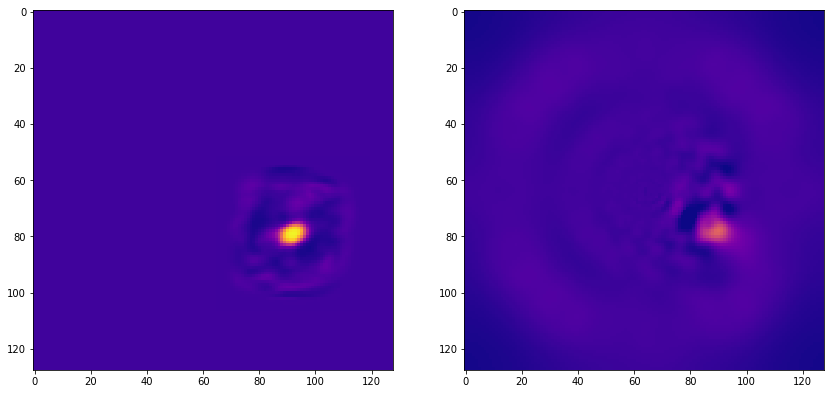

In [9]:
accuracy_colliculus, accuracy_fullfield_map = r.accuracy_fullfield(accuracy_map, i_offset, j_offset)

fig, axs = plt.subplots(1, 2, figsize = (figwidth, figwidth/2))
axs[0].imshow(accuracy_fullfield_map, vmin=0, vmax=1, cmap=plt.plasma())
axs[1].imshow(r.accuracy_invert(accuracy_colliculus), vmin=0, vmax=1, cmap=plt.plasma())


# Evaluating the accuracy of the classifier (What) wrt to spatial shifts

On commence par la fonction de base apprise de la librairie torch, cf https://raw.githubusercontent.com/pytorch/examples/master/mnist/main.py :

In [10]:
%whos

Variable                 Type        Data/Info
----------------------------------------------
Display                  type        <class 'retina.Display'>
Retina                   type        <class 'retina.Retina'>
accuracy_colliculus      ndarray     260: 260 elems, type `float64`, 2080 bytes
accuracy_fullfield_map   ndarray     128x128: 16384 elems, type `float64`, 131072 bytes (128.0 kb)
accuracy_map             ndarray     55x55: 3025 elems, type `float64`, 24200 bytes
args                     EasyDict    {'w': 28, 'minibatch_size<...>: 10, 'do_compute': True}
axs                      ndarray     2: 2 elems, type `object`, 16 bytes
d                        Display     <retina.Display object at 0x1044be7b8>
data                     Tensor      tensor([[[[-0.4242, -0.42<...>42, -0.4242, -0.4242]]]])
data_fullfield           ndarray     128x128: 16384 elems, type `float64`, 131072 bytes (128.0 kb)
data_retina              ndarray     3120: 3120 elems, type `float64`, 24960 bytes
dpi

In [11]:
from what import WhatNet
model = WhatNet()


On apprend une matrice de poids qui est fixée dans la suite et que nous allons utiliser pour la classification

In [12]:
%ls -ltr ../data/MNIST_cnn.pt
#%rm -f ../data/MNIST_cnn.pt

-rw-r--r--  1 laurentperrinet  staff  1736289 Mar 14 12:31 ../data/MNIST_cnn.pt


In [13]:
model_path = "../data/MNIST_cnn.pt"

import os
import torch
if os.path.isfile(model_path):
    print('Loading')
    model = torch.load(model_path)
    #model.load_state_dict(torch.load(model_path))
else:
    print('Learning')
    import time
    t0 = time.time()
    %run what.py --epochs 10 --save-model
    print('Done in ', time.time() - t0, 'seconds')

Loading


# A2 / architecture

https://github.com/davidstutz/latex-resources/blob/master/tikz-cnn/cnn.tex
    
  https://github.com/gwding/draw_convnet
  
  "This figure is generated by adapting the code from https://github.com/gwding/draw_convnet" 

http://nlp.motherbot.co:8093/plot?nodes=24&nodes=8&nodes=8&nodes=24



Layer 0
Layer 1


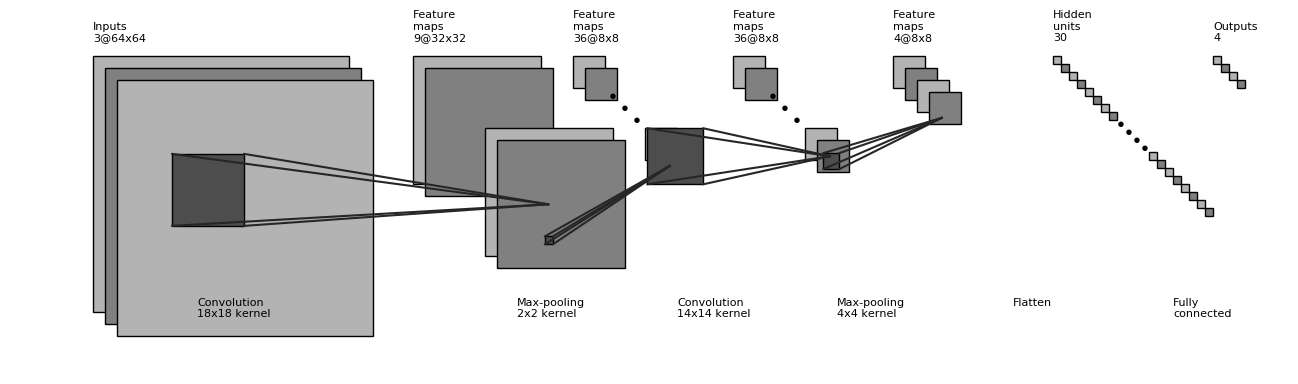

In [ ]:
"""
Copyright (c) 2017, Gavin Weiguang Ding
All rights reserved.
Redistribution and use in source and binary forms, with or without
    modification, are permitted provided that the following conditions are met:
1. Redistributions of source code must retain the above copyright notice, this
    list of conditions and the following disclaimer.
2. Redistributions in binary form must reproduce the above copyright notice,
    this list of conditions and the following disclaimer in the documentation
    and/or other materials provided with the distribution.
3. Neither the name of the copyright holder nor the names of its contributors
    may be used to endorse or promote products derived from this software
    without specific prior written permission.
THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS"
    AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE
    IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE
    ARE DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE
    LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR
    CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF
    SUBSTITUTE GOODS OR SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS
    INTERRUPTION) HOWEVER CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN
    CONTRACT, STRICT LIABILITY, OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE)
    ARISING IN ANY WAY OUT OF THE USE OF THIS SOFTWARE, EVEN IF ADVISED OF THE
    POSSIBILITY OF SUCH DAMAGE.
"""


import os
import numpy as np
import matplotlib.pyplot as plt
plt.rcdefaults()
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle
from matplotlib.patches import Circle

NumDots = 4
NumConvMax = 8
NumFcMax = 20
White = 1.
Light = 0.7
Medium = 0.5
Dark = 0.3
Darker = 0.15
Black = 0.


def add_layer(patches, colors, size=(24, 24), num=5,
              top_left=[0, 0],
              loc_diff=[3, -3],
              ):
    # add a rectangle
    top_left = np.array(top_left)
    loc_diff = np.array(loc_diff)
    loc_start = top_left - np.array([0, size[0]])
    for ind in range(num):
        patches.append(Rectangle(loc_start + ind * loc_diff, size[1], size[0]))
        if ind % 2:
            colors.append(Medium)
        else:
            colors.append(Light)


def add_layer_with_omission(patches, colors, size=(24, 24),
                            num=5, num_max=8,
                            num_dots=4,
                            top_left=[0, 0],
                            loc_diff=[3, -3],
                            ):
    # add a rectangle
    top_left = np.array(top_left)
    loc_diff = np.array(loc_diff)
    loc_start = top_left - np.array([0, size[0]])
    this_num = min(num, num_max)
    start_omit = (this_num - num_dots) // 2
    end_omit = this_num - start_omit
    start_omit -= 1
    for ind in range(this_num):
        if (num > num_max) and (start_omit < ind < end_omit):
            omit = True
        else:
            omit = False

        if omit:
            patches.append(
                Circle(loc_start + ind * loc_diff + np.array(size) / 2, 0.5))
        else:
            patches.append(Rectangle(loc_start + ind * loc_diff,
                                     size[1], size[0]))

        if omit:
            colors.append(Black)
        elif ind % 2:
            colors.append(Medium)
        else:
            colors.append(Light)


def add_mapping(patches, colors, start_ratio, end_ratio, patch_size, ind_bgn,
                top_left_list, loc_diff_list, num_show_list, size_list):

    start_loc = top_left_list[ind_bgn] \
        + (num_show_list[ind_bgn] - 1) * np.array(loc_diff_list[ind_bgn]) \
        + np.array([start_ratio[0] * (size_list[ind_bgn][1] - patch_size[1]),
                    - start_ratio[1] * (size_list[ind_bgn][0] - patch_size[0])]
                   )

    end_loc = top_left_list[ind_bgn + 1] \
        + (num_show_list[ind_bgn + 1] - 1) * np.array(
            loc_diff_list[ind_bgn + 1]) \
        + np.array([end_ratio[0] * size_list[ind_bgn + 1][1],
                    - end_ratio[1] * size_list[ind_bgn + 1][0]])


    patches.append(Rectangle(start_loc, patch_size[1], -patch_size[0]))
    colors.append(Dark)
    patches.append(Line2D([start_loc[0], end_loc[0]],
                          [start_loc[1], end_loc[1]]))
    colors.append(Darker)
    patches.append(Line2D([start_loc[0] + patch_size[1], end_loc[0]],
                          [start_loc[1], end_loc[1]]))
    colors.append(Darker)
    patches.append(Line2D([start_loc[0], end_loc[0]],
                          [start_loc[1] - patch_size[0], end_loc[1]]))
    colors.append(Darker)
    patches.append(Line2D([start_loc[0] + patch_size[1], end_loc[0]],
                          [start_loc[1] - patch_size[0], end_loc[1]]))
    colors.append(Darker)


def label(xy, text, xy_off=[0, 4]):
    plt.text(xy[0] + xy_off[0], xy[1] + xy_off[1], text,
             family='sans-serif', size=8)


# MAIN
fc_unit_size = 2
layer_width = 40

flag_omit = False
flag_omit = True


patches = []
colors = []

fig, ax = plt.subplots(figsize=(16, 4))

############################
# conv layers
size_list = [(32, 32), (18, 18), (10, 10), (6, 6), (4, 4)]
num_list = [3, 32, 32, 48, 48]
size_list = [(64, 64), (32, 32), (8, 8), (8, 8), (8, 8)]
num_list = [3, 9, 36, 36, 4]


#x_diff_list = [0, layer_width, layer_width, layer_width, layer_width]
x_diff_list = [0]
x_diff_list.append(80)
for _ in num_list[2:]:
    x_diff_list.append(layer_width)


text_list = ['Inputs'] + ['Feature\nmaps'] * (len(size_list) - 1)
loc_diff_list = [[3, -3]] * len(size_list)

num_show_list = list(map(min, num_list, [NumConvMax] * len(num_list)))
top_left_list = np.c_[np.cumsum(x_diff_list), np.zeros(len(x_diff_list))]

for ind in range(len(size_list)-1,-1,-1):
    if flag_omit:
        add_layer_with_omission(patches, colors, size=size_list[ind],
                                num=num_list[ind],
                                num_max=NumConvMax,
                                num_dots=NumDots,
                                top_left=top_left_list[ind],
                                loc_diff=loc_diff_list[ind])
    else:
        add_layer(patches, colors, size=size_list[ind],
                  num=num_show_list[ind],
                  top_left=top_left_list[ind], loc_diff=loc_diff_list[ind])
    label(top_left_list[ind], text_list[ind] + '\n{}@{}x{}'.format(
        num_list[ind], size_list[ind][0], size_list[ind][1]))


############################
# in between layers
start_ratio_list = [[0.3, 0.5], [0.4, 0.8], [0.4, 0.5], [0.4, 0.8]]
start_ratio_list = [[0.3, 0.4], [0.4, 0.8], [0.4, 0.5], [0.4, 0.8]]

end_ratio_list = [[0.4, 0.5], [0.4, 0.8], [0.4, 0.5], [0.4, 0.8]]
patch_size_list = [(18, 18), (2, 2), (14, 14), (4, 4)]
ind_bgn_list = range(len(patch_size_list))
text_list = ['Convolution', 'Max-pooling', 'Convolution', 'Max-pooling']

for ind in range(len(patch_size_list)):
    add_mapping(
        patches, colors, start_ratio_list[ind], end_ratio_list[ind],
        patch_size_list[ind], ind,
        top_left_list, loc_diff_list, num_show_list, size_list)
    label(top_left_list[ind], text_list[ind] + '\n{}x{} kernel'.format(
        patch_size_list[ind][0], patch_size_list[ind][1]), xy_off=[26, -65]
    )


############################
# fully connected layers
num_list = [30, 4]
size_list = [(fc_unit_size, fc_unit_size)] * len(num_list)
num_show_list = list(map(min, num_list, [NumFcMax] * len(num_list)))
x_diff_list = [sum(x_diff_list) + layer_width, layer_width, layer_width]
top_left_list = np.c_[np.cumsum(x_diff_list), np.zeros(len(x_diff_list))]
loc_diff_list = [[fc_unit_size, -fc_unit_size]] * len(top_left_list)
text_list = ['Hidden\nunits'] * (len(size_list) - 1) + ['Outputs']

for ind in range(len(size_list)):
    print('Layer', ind)
    if flag_omit:
        add_layer_with_omission(patches, colors, size=size_list[ind],
                                num=num_list[ind],
                                num_max=NumFcMax,
                                num_dots=NumDots,
                                top_left=top_left_list[ind],
                                loc_diff=loc_diff_list[ind])
    else:
        add_layer(patches, colors, size=size_list[ind],
                  num=num_show_list[ind],
                  top_left=top_left_list[ind],
                  loc_diff=loc_diff_list[ind])
    label(top_left_list[ind], text_list[ind] + '\n{}'.format(
        num_list[ind]))

text_list = ['Flatten\n', 'Fully\nconnected', 'Fully\nconnected']

for ind in range(len(size_list)):
    label(top_left_list[ind], text_list[ind], xy_off=[-10, -65])

############################
for patch, color in zip(patches, colors):
    patch.set_color(color * np.ones(3))
    if isinstance(patch, Line2D):
        ax.add_line(patch)
    else:
        patch.set_edgecolor(Black * np.ones(3))
        ax.add_patch(patch)

#plt.tight_layout()
plt.axis('equal')
plt.axis('off')
plt.show()
#fig.set_size_inches(15, 8)

if False:
    fig_dir = './'
    fig_ext = '.pdf'
    fig.savefig(os.path.join(fig_dir, 'CNN' + fig_ext),
            bbox_inches='tight', pad_inches=0)

## Using the learned classifier in a standalone class

Maintenant qu'on a appris les points qui permet une classification d'à peu près 98 % on va utiliser le modèle fead-forward pour faire la classification.

In [ ]:
from retina import Display
d = Display(args)
data, label = next(iter(d.loader_test))

## shifting the input images


Je vais maintenant générer des données en utilisant les données originales de MNIST translatées :

In [ ]:
from torchvision import datasets, transforms
i_shift, j_shift = 12, 17
N_pix = 28

In [ ]:
from retina import Display
d = Display(args)
data, label = next(iter(d.loader_test))

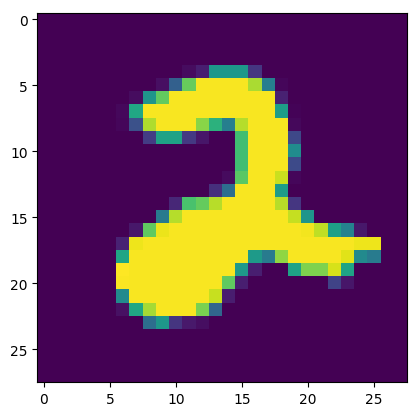

In [ ]:
fig, ax = plt.subplots()
ax.imshow(data[0, 0, :, :].numpy())

(10000, 1, 82, 82)


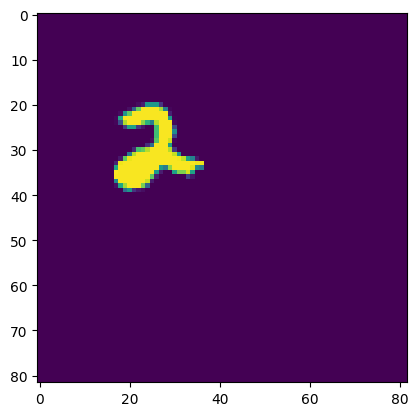

In [ ]:
data = data.numpy()
data_translate = data.min() * np.ones((data.shape[0], 1, N_pix*3 - 2, N_pix*3 - 2))
print(data_translate.shape)
data_translate[:, :, (N_pix-i_shift):(2*N_pix-i_shift), (N_pix-j_shift):(2*N_pix-j_shift)] = data
fig, ax = plt.subplots()
ax.imshow(data_translate[0, 0, :, :])

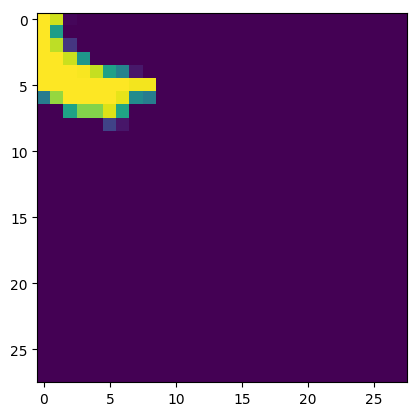

In [ ]:
data_cropped = data_translate[:, :, (N_pix):(2*N_pix), (N_pix):(2*N_pix)]
fig, ax = plt.subplots()
ax.imshow(data_cropped[0, 0, :, :])

In [ ]:
np.arange(-N_pix+1, N_pix)

array([-27, -26, -25, -24, -23, -22, -21, -20, -19, -18, -17, -16, -15,
       -14, -13, -12, -11, -10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,
        -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
        12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,
        25,  26,  27])

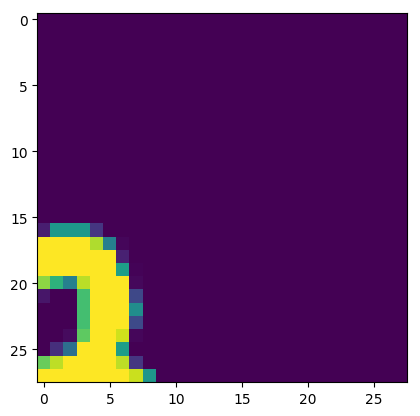

In [ ]:
def shift_data(data, i_shift, j_shift):
    N_pix = data.shape[-1]
    assert(N_pix == data.shape[-2])
    import numpy as np
    data_translate = data.min() * np.ones((data.shape[0], 1, N_pix*3 - 1, N_pix*3 - 1))
    data_translate[:, :, (N_pix+i_shift):(2*N_pix+i_shift), (N_pix+j_shift):(2*N_pix+j_shift)] = data
    data_cropped = data_translate[:, :, (N_pix):(2*N_pix), (N_pix):(2*N_pix)]
    return data_cropped

data_cropped = shift_data(data, i_shift = 12, j_shift = -12)
fig, ax = plt.subplots()
ax.imshow(data_cropped[0, 0, :, :])

## Using the learned classifier on the shifted data

On peut maintenant tester le classifieur sur les images Translatées en calculant la valeur de classification en  fonction de l'erreur de localisation

In [ ]:
def test_shift(test_loader, i_shift, j_shift, verbose=0):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data_cropped = shift_data(data, i_shift=i_shift, j_shift=j_shift)        
        data_cropped = torch.FloatTensor(data_cropped) #transforms.ToTensor()(data_cropped)
        data_cropped, target = Variable(data_cropped, volatile=True), Variable(target)
        output = model(data_cropped)
        test_loss += F.nll_loss(output, target, size_average=False).data[0] # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    if verbose: print('\nTest set: at ({}, {}), the  average loss is {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        i_shift, j_shift, test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return correct / len(test_loader.dataset)


path = "../data/MNIST_accuracy.npy"

import os
if os.path.isfile(path):
    print('Loading accuracy')
    accuracy = np.load(path)
else:
    print('Computing accuracy')
    import time
    t0 = time.time()
    accuracy = np.zeros((2*N_pix-1, 2*N_pix-1))
    from tqdm import tqdm
    N_step = 1

    with tqdm(total=(2*N_pix-1)**2/N_step**2) as pbar:
        for i_shift in np.arange(-N_pix+1, N_pix, N_step):
            for j_shift in np.arange(-N_pix+1, N_pix, N_step):
                accuracy[i_shift+N_pix-1, j_shift+N_pix-1] = test_shift(test_loader, i_shift, j_shift)
                pbar.update()
    np.save(path, accuracy)
    print('Done in ', time.time() - t0, 'seconds')
    
print('accuracy=', accuracy)    

Loading accuracy
accuracy= [[0.0974 0.0974 0.0974 ... 0.0974 0.0974 0.0974]
 [0.0974 0.0974 0.0974 ... 0.0974 0.0974 0.0974]
 [0.0974 0.0974 0.0974 ... 0.0974 0.0974 0.0974]
 ...
 [0.0974 0.0974 0.0974 ... 0.0974 0.0974 0.0974]
 [0.0974 0.0974 0.0974 ... 0.0974 0.0974 0.0974]
 [0.0974 0.0974 0.0974 ... 0.0974 0.0974 0.0974]]


J'avoue que c'est un peu bourrin de calculer la classification sur les 128 × 128 pixels pour 1000 batch multiplié par 10 type d'entrées.... Mais bon on doit faire ça seulement une fois :-) (et sur CPU une classif = environ 300µs ...)

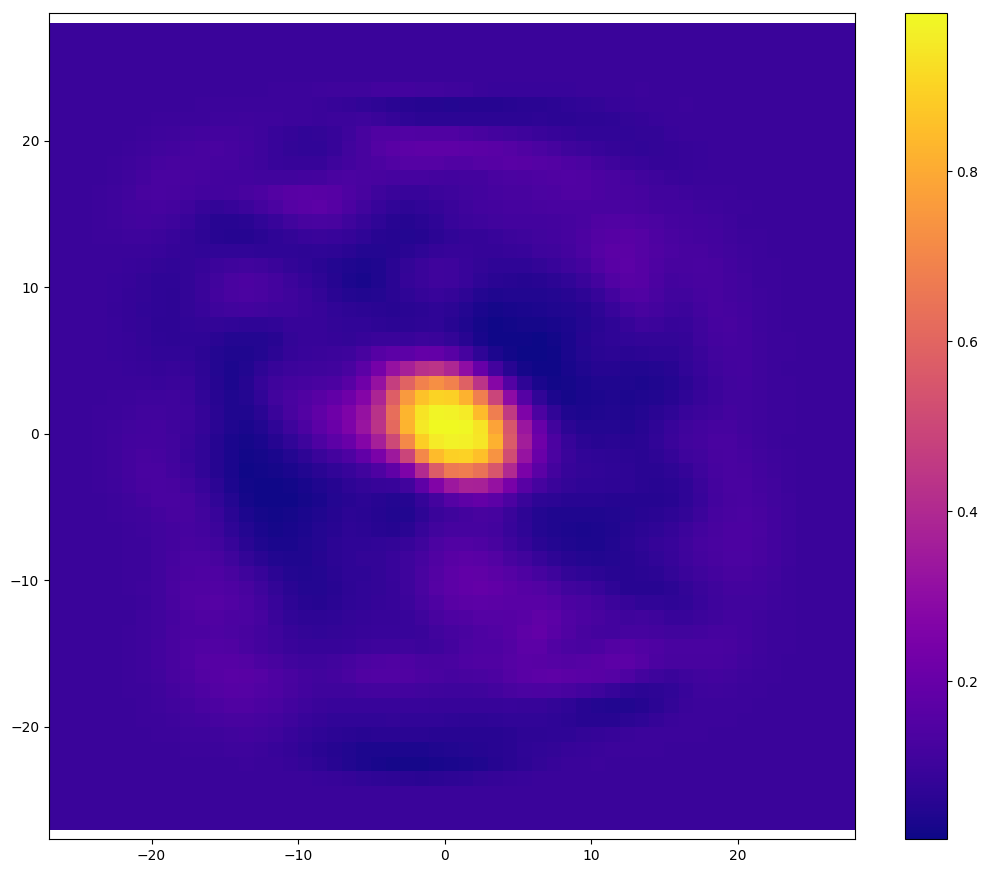

In [ ]:
fig, ax = plt.subplots(figsize=(13, 10.725))
cmap = ax.pcolor(np.arange(-N_pix+1, N_pix+1), np.arange(-N_pix+1, N_pix+1), accuracy, cmap=plt.plasma())
ax.axis('equal')
fig.colorbar(cmap)

Cette fonction de performance du classifieur  est calculée indépendamment de la forme spécifique du chiffre entre 0 et 9. Elle donne donc la carte de performance qu'on attend Au niveau de la classification/ On va pouvoir maintenant l'utiliser ceomm label pour apprendre de façon supervisée la correspondance entre la carte log-polaire obtenue depuis l'image brute et cette carte de performance.

# Retinotopic mapping

## Orientation invariant power encoding (colliculus??)

In [ ]:
from retina import Retina
r = Retina(args)

In [ ]:
print('r.colliculus.shape=', r.colliculus.shape)

In [ ]:
print('r.colliculus_vector.shape=', r.colliculus_vector.shape)

In [ ]:
print('r.colliculus_inverse.shape=', r.colliculus_inverse.shape)

In [ ]:
energy = (r.retina_transform**2).sum(axis=(0,3)) 
energy /= energy.sum(axis=-1)[:, :, None]
energy_vector = energy.reshape((args.N_azimuth*args.N_eccentricity, args.N_pic**2))
energy_plus = np.linalg.pinv(energy_vector)
FIG_WIDTH = 5 

fig, ax = plt.subplots(figsize=(figwidth, figwidth))
for i_orient in range(args.N_azimuth):
    for i_scale in range(args.N_eccentricity):
        env = np.sqrt(energy[i_orient, i_scale, :]**2.5).reshape((args.N_pic, args.N_pic))
        ax.contour(energy[i_orient, i_scale, :].reshape((args.N_pic, args.N_pic)), levels=[env.max()/2], lw=1,
                  colors=[plt.cm.rainbow(i_scale * 1.5/args.N_azimuth)])
fig.suptitle('Tiling of visual space using energy', y=1.02)
ax.set_xlabel(r'$Y$')
ax.set_ylabel(r'$X$')
ax.axis('equal')
plt.tight_layout()

# summary


In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (figwidth, figwidth/3.618))
ax_A = plt.subplot(1, 3, 1) 
#data_retina = where.retina.retina(full[idx]['data_fullfield'])
#ax_A = where.retina.show(ax_A, where.retina.retina_invert(data_retina))
    
ax_B = plt.subplot(1, 3, 2)
for i_orient in range(0, args.N_azimuth, 2):
    for i_scale in range(1, args.N_eccentricity, 2):
        env = np.sqrt(energy[i_orient, i_scale, :]**2.5).reshape((args.N_pic, args.N_pic))
        ax_B.contour(energy[i_orient, i_scale, :].reshape((args.N_pic, args.N_pic)), levels=[env.max()/2], lw=.1,
                  colors=[plt.cm.rainbow(i_scale * 1.5/args.N_azimuth)])
ax_B.set_xlabel(r'$Y$')
ax_B.set_ylabel(r'$X$')
ax_B.axis('square')

ax_C = plt.subplot(1, 3, 3)
cmap = ax_C.pcolor(np.arange(-N_pix+1, N_pix+1), np.arange(-N_pix+1, N_pix+1), accuracy, cmap=plt.plasma())
ax_C.axis('square')
ax_C.set_xlabel(r'$\Delta Y$')
ax_C.set_ylabel(r'$\Delta X$')
fig.colorbar(cmap)


for ax, text, x_offset, y_offset in [[ax_A, 'A', -.35, .95], [ax_B, 'B', -.35, .95], [ax_C, 'C', -.35, .95]]:
    ax.text(x_offset, y_offset, '(' + text + ')', fontsize=24,
              bbox={'facecolor':'white','alpha':1,'edgecolor':'none','pad':1},
              ha='left', va='center', transform=ax.transAxes) 
plt.tight_layout()

fig.savefig(figname + '.pdf', bbox_inches='tight', pad_inches=0.1)

# post-processing

In [ ]:
!convert  -density {dpi_export} {figname}.pdf {figname}.jpg
!convert  -density {dpi_export} {figname}.pdf {figname}.png
#!convert  -density {dpi_export} -resize 5400  -units pixelsperinch -flatten  -compress lzw  -depth 8 {fname}.pdf {fname}.tiff

In [ ]:
from IPython.display import Image
Image('{figname}.png'.format(figname=figname))

In [ ]:
!ls  -l {figname}*